In [1]:
from __future__ import division

import os
import matplotlib.pyplot as plt
import numpy as np
import skbio
import scipy.stats
import statsmodels.api as sms
import statsmodels.formula.api as smf

import absloute_power.traditional as trad
import absloute_power.utils as ap


import pandas as pd
import biom

from skbio.stats.power import subsample_power, subsample_paired_power

from absloute_power.traditional import calc_ttest_1

import pickle

In [2]:
from matplotlib import rcParams



# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

% matplotlib inline

In [3]:
base_dir = '/Users/jwdebelius/Repositories/Absloute-Power'
data_dir = os.path.join(base_dir, 'data/merged_otu_table_and_mapping_bmi/region_hmp')
map_fp = os.path.join(data_dir, 'hmp_map_clean.txt')
otu_fp = os.path.join(data_dir, 'merged_bmi_otu_1k__original_study_HMP__.biom')
uud_fp = os.path.join(data_dir, 'pcoas/unweighted_unifrac_dm.txt')

In [9]:
map_ = pd.read_csv(map_fp, sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)
uud = skbio.DistanceMatrix.read(uud_fp)

In [10]:
inter_ids = list(set(map_.index).intersection(set(uud.ids)))

In [11]:
map_ = map_.loc[inter_ids]
uud = uud.filter(inter_ids)

In [13]:
map_.columns

Index([u'BARCODE', u'LinkerPrimerSequence', u'AGE', u'BMI', u'bmi_group_coded',
       u'body_site', u'COLLECTION_DATE', u'combined_study_bmi_group',
       u'COUNTRY', u'EXPERIMENT_CENTER', u'HMP_body_subsite',
       u'HMP_body_supersite', u'host_subject_id', u'LATITUDE',
       u'LinkerPrimerSequence.1', u'LONGITUDE', u'merged_category_bmi',
       u'merged_weight_cats_study', u'original_study', u'PCR_PRIMERS',
       u'PLATFORM', u'REGION', u'RUN_CENTER', u'Run_id', u'SAMPLE_ACCESSION',
       u'SAMPLE_CENTER', u'SAMPLE_CENTER.1', u'SEQUENCING_METH', u'SEX',
       u'STUDY_CENTER', u'TARGET_SUBFRAGMENT', u'Description'],
      dtype='object')

In [48]:
map_.groupby(['merged_category_bmi']).count().max(1)

merged_category_bmi
Normal    112
OvOb       89
dtype: int64

In [31]:
map_.loc[map_.TARGET_SUBFRAGMENT == 'V35'].groupby('bmi_group_coded').count().max(1)

bmi_group_coded
Normal        56
Obese         11
Overweight    27
dtype: int64

I'd like to compare the studies for healthy adults. So, I'm going to compare the studies without filtering, and then compare by filtering on lean western adults, only.

In [41]:
def test_beta_permanova(ids, meta, dm, cat, num_iter=999):
    """Tests difference in beta diversity for a category and distance matrix"""
    # Gets the map and distance matrix subset
    all_ids = np.hstack(ids)
    # Calculates the permanova
    perma_results = skbio.stats.distance.permanova(dm.filter(all_ids), 
                                                   meta.loc[all_ids],
                                                   cat,
                                                   num_iter)
    # Returns the p value
    return perma_results['p-value']

In [42]:
reg_test = lambda x: test_beta_permanova(x, map_, uud, 'TARGET_SUBFRAGMENT')

In [43]:
center_test = lambda x: test_beta_permanova(x, map_, uud, 'STUDY_CENTER')

In [52]:
bmi_test = lambda x: test_beta_permanova(x, map_, uud, 'merged_category_bmi')

In [53]:
reg_ids = [i for i in map_.groupby('TARGET_SUBFRAGMENT').groups.itervalues()]
cen_ids = [map_.loc[map_.TARGET_SUBFRAGMENT == 'V35'].groupby('STUDY_CENTER').groups[g] for g in ['BI', 'JCVI']]
bmi_ids = [i for i in map_.loc[map_.TARGET_SUBFRAGMENT == 'V35'].groupby('merged_category_bmi').groups.itervalues()]

In [35]:
reg_power, reg_counts = subsample_power(reg_test,
                                        reg_ids,
                                        min_counts=3,
                                        max_counts=14,
                                        counts_interval=1,
                                        num_runs=5,
                                        alpha_pwr=0.02)

In [36]:
cen_power, cen_counts = subsample_power(center_test,
                                        cen_ids,
                                        min_counts=3,
                                        max_counts=25,
                                        counts_interval=2,
                                        alpha_pwr=0.02,
                                        num_runs=5)

In [37]:
bmi_power, bmi_counts = subsample_power(bmi_test,
                                        bmi_ids,
                                        min_counts=3,
                                        max_counts=25,
                                        counts_interval=2,
                                        alpha_pwr=0.02,
                                        num_runs=5)

In [38]:
study = {'region': [reg_power, reg_counts],
         'center': [cen_power, cen_counts],
         'bmi': [bmi_power, bmi_counts],
        }

In [45]:
reg_test(reg_ids)

0.001

In [46]:
center_test(cen_ids)

0.001

In [54]:
bmi_test(bmi_ids)

0.078

In [39]:
for k, (pwr, cnt) in study.iteritems():
    eff = ap.z_effect(cnt, pwr, 0.05)
    n = np.sum(np.isnan(eff) == False)
    print k, np.round(np.nanmean(eff), 2),  np.round(np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1), 2)

region 1.48 0.18
bmi 0.25 0.05
center 0.32 0.04


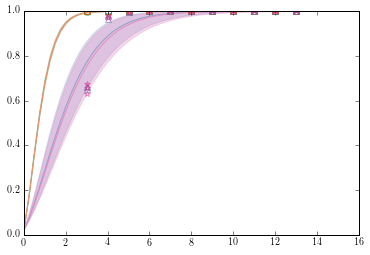

In [74]:
ax = plt.axes()

ax.fill_between(np.arange(0, 15.1, 0.25), 
                ap.z_power(np.arange(0, 15.1, 0.25), 3.90, 0.02), 
                ap.z_power(np.arange(0, 15.1, 0.25), 4., 0.02), 
                color='#66c2a5', alpha=0.33)
ax.fill_between(np.arange(0, 15.1, 0.25), 
                ap.z_power(np.arange(0, 15.1, 0.25), 3.90, 0.02), 
                ap.z_power(np.arange(0, 15.1, 0.25), 4., 0.02), 
                color='#fc8d62', alpha=0.33)
ax.fill_between(np.arange(0, 15.1, 0.25), 
                ap.z_power(np.arange(0, 15.1, 0.25), 2.51-0.29, 0.02), 
                ap.z_power(np.arange(0, 15.1, 0.25), 2.51+0.29, 0.02), 
                color='#8da0cb', alpha=0.33)
ax.fill_between(np.arange(0, 15.1, 0.25), 
                ap.z_power(np.arange(0, 15.1, 0.25), 2.46-0.29, 0.02), 
                ap.z_power(np.arange(0, 15.1, 0.25), 2.46+0.29, 0.02), 
                color='#e78ac3', alpha=0.33)

ax.plot(np.arange(0, 15.1, 0.25), ap.z_power(np.arange(0, 15.1, 0.25), 3.95, 0.02), '#66c2a5')
ax.plot(np.arange(0, 15.1, 0.25), ap.z_power(np.arange(0, 15.1, 0.25), 3.95, 0.02), '#fc8d62')
ax.plot(np.arange(0, 15.1, 0.25), ap.z_power(np.arange(0, 15.1, 0.25), 2.51, 0.02), '#8da0cb')
ax.plot(np.arange(0, 15.1, 0.25), ap.z_power(np.arange(0, 15.1, 0.25), 2.46, 0.02), '#e78ac3')

for idx in xrange(3):
    plt.plot(s_a_counts, s_a_power[idx, :], 'o', mfc='none', mec='#1b9e77')
    plt.plot(sma_counts, sma_power[idx, :], 's', mfc='none', mec='#d95f02')
    plt.plot(sva_counts, sva_power[idx, :], '^', mfc='none', mec='#7570b3')
    plt.plot(smv_counts, smv_power[idx, :], '*', mfc='none', mec='#e7298a')
    
    

2.17

In [ ]:
2.65 - 0.43

In [ ]:
target_ids = [g for g in hmp_map.groupby('TARGET_SUBFRAGMENT').groups.itervalues()]

In [ ]:
target_test = lambda x: test_beta_permanova(x, hmp_map, uud, 'TARGET_SUBFRAGMENT')

In [ ]:
tar_power, tar_counts = subsample_power(target_test,
                                        target_ids,
                                        min_counts=3,
                                        max_counts=14,
                                        counts_interval=1,
                                        num_runs=3,
                                        alpha_pwr=0.02)

In [ ]:
tar_power

In [ ]:
tar_counts

In [ ]:
eff = ap.z_effect(tar_counts, tar_power, 0.02)
n = np.sum(np.isnan(eff) == False)
print 'target', np.nanmean(eff), np.nanstd(eff) / np.sqrt(n) * scipy.stats.t.ppf(0.975, n-1)

In [ ]:
map_.groupby('original_study').count().max(1)